In [1]:
import numpy as np
import os
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
import matplotlib
import matplotlib.pyplot as plt
font = {'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

In [2]:
# This analysis is based on 10 K-Fold with fixed selection
os.chdir('/home/bxie/PycharmProjects/KDEL/benchmark/building_new_model/95_training_database_predict_104batch_validation/rnn_modular_package/Validation_fixed')

In [3]:
# Read original data and prediction data #

if os.path.exists('cross_validation_results.txt'):
    f = open('cross_validation_results.txt','r')
    lines=f.read().split('\n')
    f.close()
    tem = lines[1:-1]
    original_data ={}
    predict_data = {}

    mark = []
    for i in range(len(tem)):
        if 'Model' in tem[i]:
            mark.append(i)
    for m in range(len(mark)-1):
        original_data['model'+tem[mark[m]].split()[1]+'_split'+tem[mark[m]].split()[3]] = [float(x.split()[0]) for x in tem[mark[m]+1:mark[m+1]]]
        predict_data['model'+tem[mark[m]].split()[1]+'_split'+tem[mark[m]].split()[3]] = [float(x.split()[1]) for x in tem[mark[m]+1:mark[m+1]]]
    original_data['model'+tem[mark[-1]].split()[1]+'_split'+tem[mark[-1]].split()[3]] = [float(x.split()[0]) for x in tem[mark[-1]+1:]]
    predict_data['model'+tem[mark[-1]].split()[1]+'_split'+tem[mark[-1]].split()[3]] = [float(x.split()[1]) for x in tem[mark[-1]+1:]]

else:
    f = open('nohup.out','r')
    lines = f.read().split('\n')
    f.close()
    f = open('cross_validation_results.txt','w')
    f.write('#data      prediction \n')

    start_key = '#data_y predict_y'
    end_key = '===================='

    original_data ={}
    predict_data = {}

    starting_index = []
    ending_index = []
    for i in range(len(lines)):
        if start_key in lines[i]:
            starting_index.append(i)
        if end_key in lines[i]:
            ending_index.append(i) # 320, every model has 10 set. Total has 32 models

    index = 0
    for i in range(32):
        for j in range(10):
            f.write('Model '+str(i)+' Fold '+str(j)+'\n')
            if j ==0:
                model_num = lines[starting_index[index]-265].split()[-1].split('_')[1]
            original_data['model'+model_num+'_split'+str(j)] = []
            predict_data['model'+model_num+'_split'+str(j)] = []
            tem = lines[starting_index[index]: ending_index[index]]
            for t in range(1,len(tem)):
                if t%2 ==0:
                    original_data['model'+model_num+'_split'+str(j)].append(float(tem[t].split()[0]))
                    predict_data['model'+model_num+'_split'+str(j)].append(float(tem[t].split()[1]))
                    f.write(tem[t].split()[0]+' '+tem[t].split()[1]+'\n')
            index+=1
    f.close()


In [10]:
def read_prediction_data(cross_validation_txt):
    model_num = int(cross_validation_txt.split('_')[3])
    split_num = int(cross_validation_txt.split('.')[0].split('_')[-1][4:])
    data = np.loadtxt(cross_validation_txt)
    orig_data = []
    pre_data = []
    for d in data:
        orig_data.append(d[0])
        pre_data.append(d[1])
    return orig_data, pre_data, model_num, split_num

In [4]:
### Read Epoch vs loss data ###
### calculate Loss for different Epoch ###
f = open('nohup.out','r')
lines=f.read().split('\n')
f.close()
_data =[]
for i in range(len(lines)):
    if 'Epoch: ' in lines[i]:
        _data.append(lines[i])

epoch_nums = []
for d in _data:
    epoch_nums.append(int(d.split()[1].split('/')[0]))
epoch_nums = sorted(list(set(epoch_nums)))

epoch_data = {}
for num in epoch_nums:
    for d in _data:
        if not num in epoch_data.keys():
            epoch_data[num] = []
        if str(num)+'/3000' in d:
            epoch_data[num].append(float(d.split()[-1]))


In [5]:
def r2_np(x_values,y_values):
    correlation_matrix = np.corrcoef(x_values, y_values)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return r_squared
def r_np(x_values,y_values):
    correlation_matrix = np.corrcoef(x_values, y_values)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy
def pearson(x_values,y_values):
    pearson_r = stats.pearsonr(x_values, y_values)
    return pearson_r
def spearman(x_values,y_values):
    spearman_r = stats.spearmanr(x_values, y_values)
    return spearman_r
def kendall(x_values,y_values):
    kendall_tau = stats.kendalltau(x_values, y_values)
    return kendall_tau

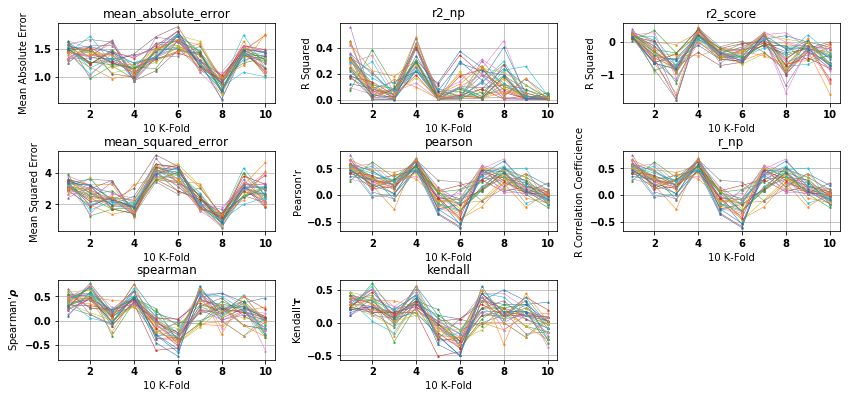

In [6]:
y_axis_labels = {}
y_axis_labels['mean_absolute_error']='Mean Absolute Error'
y_axis_labels['r2_np']='R Squared'    #through numpy.corrcoef
y_axis_labels['r2_score']='R Squared' #through sklearn.metrics
y_axis_labels['mean_squared_error']='Mean Squared Error'
y_axis_labels['pearson']='Pearson'+"'"+'r'
y_axis_labels['r_np'] = 'R Correlation Coefficience'
y_axis_labels['spearman']= 'Spearman'+"'"+r'$\rho$'
y_axis_labels['kendall'] = 'Kendall'+"'"+r'$\tau$'
condition_list = list(y_axis_labels.keys())

plt.clf()
plt.figure(figsize=(14,18))
plot_index=1

for c in condition_list:
    plt.subplot(len(condition_list), 3, plot_index)
    for i in range(32):
        data = []
        for j in range(10):
            y = []
            pred = []
            model_key = 'model'+str(i)+'_split'+str(j)
            for o in original_data[model_key]:
                y.append(o)
            for p in predict_data[model_key]:
                pred.append(p)
            y_ = np.array(y) 
            pred_ = np.array(pred)
            correlation = locals()[c](y_, pred_)
            if 'pearson' in c or 'spearman' in c or 'kendall' in c:
                correlation = correlation[0]
            data.append(correlation)
        plt.plot(data,'-^', lw = 0.5,markersize=1.5)
    plt.title(c)
    plt.xticks([1,3,5,7,9],['2','4','6','8','10'])
    plt.ylabel(y_axis_labels[c])
    plt.grid(axis='y',alpha=0.9)
    plt.grid(axis='x',alpha=0.9)
    plt.xlabel('10 K-Fold')
    plot_index+=1
plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(wspace=0.3)
plt.show()


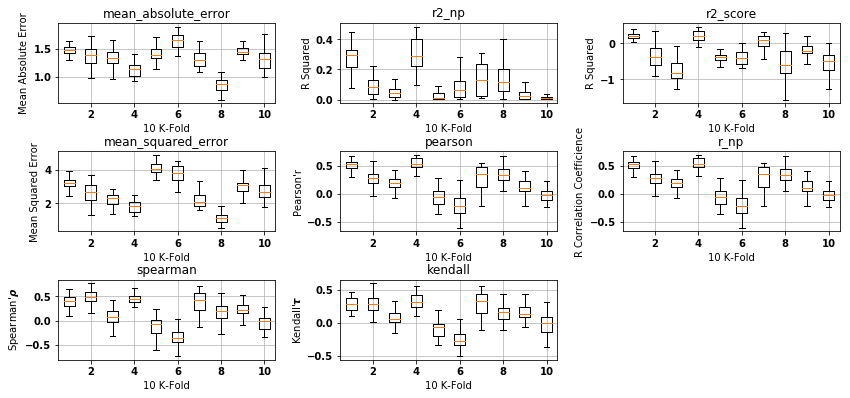

In [7]:
# Box plot
plt.clf()
plt.figure(figsize=(14,18))
plot_index=1

# Didn't do average, Didn't do bootstraping

for c in condition_list:
    box_data =[]
    plt.subplot(len(condition_list), 3, plot_index)
    for j in range(10):# 10 fold
        data = []
        for i in range(32):
            y = []
            pred = []
            model_key = 'model'+str(i)+'_split'+str(j)
            for o in original_data[model_key]:
                y.append(o)
            for p in predict_data[model_key]:
                pred.append(p)
            y_ = np.array(y)       
            pred_ = np.array(pred)
            correlation = locals()[c](y_, pred_)
            if 'pearson' in c or 'spearman' in c or 'kendall' in c:
                correlation = correlation[0]
            data.append(correlation)
        box_data.append(data)
    plt.boxplot(box_data, showfliers=False)    
    plt.title(c)
    plt.xticks([2,4,6,8,10],['2','4','6','8','10'])
    plt.ylabel(y_axis_labels[c])
    plt.grid(axis='y',alpha=0.9)
    plt.grid(axis='x',alpha=0.9)
    plt.xlabel('10 K-Fold')
    plot_index+=1
plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(wspace=0.3)
plt.show()


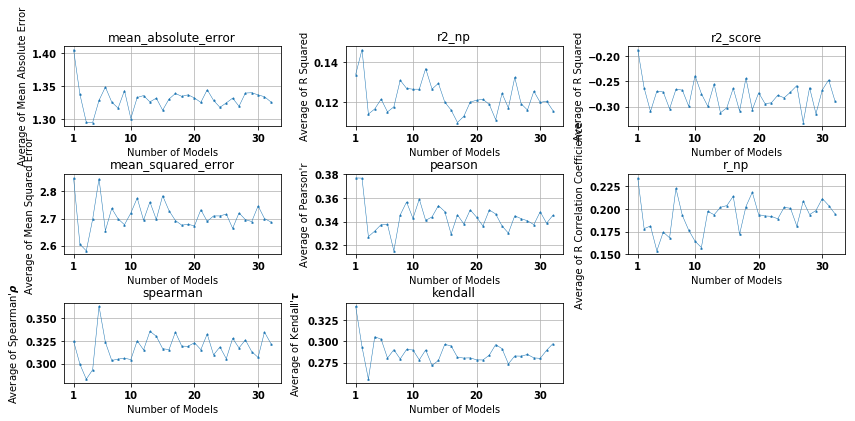

In [8]:
plt.clf()
plt.figure(figsize=(14,18))
plot_index=1

for c in condition_list:
    plt.subplot(len(condition_list), 3, plot_index)
    multi_models_r = []
    multi_models_r_std = []
    for msize in range(1,33):
        mean_r_based_on_multi_models = []
        for _ in range(100):        # bootstrap 100 times for selecting random models.
            select_modes = np.random.choice(32,msize)
            data = []
            for i in select_modes:
                for j in range(10):
                    y = []
                    pred = []
                    model_key = 'model'+str(i)+'_split'+str(j)
                    for o in original_data[model_key]:
                        y.append(o)
                    for p in predict_data[model_key]:
                        pred.append(p)
                    y_ = np.array(y) # cumulate models
                    pred_ = np.array(pred)
                    correlation = locals()[c](y_, pred_)
                    data.append(correlation)
            tem_mean_r = np.mean(data) # average selected models
        mean_r_based_on_multi_models.append(tem_mean_r)
        multi_models_r.append(np.mean(mean_r_based_on_multi_models))
        multi_models_r_std.append(np.std(mean_r_based_on_multi_models))
    plt.errorbar(range(32),multi_models_r,yerr=multi_models_r_std, fmt='-^', lw = 0.5,markersize=1.5)
    plt.title(c)
    plt.xticks([0,9,19,29],['1','10','20','30'])
    plt.ylabel('Average of '+y_axis_labels[c])
    plt.grid(axis='y',alpha=0.9)
    plt.grid(axis='x',alpha=0.9)
    plt.xlabel('Number of Models')
    plot_index+=1
plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(wspace=0.3)
plt.show()

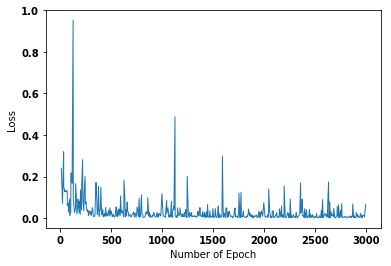

In [9]:
plt.clf()
plt.figure()
nums_of_epoch = sorted(epoch_data.keys())
loss_values = []
for num in nums_of_epoch:
    tem =[]
    for _ in range(1000):
        select_num = np.random.choice(32,32)
        tem.append(np.mean([epoch_data[num][s] for s in select_num]))
    loss_values.append(np.mean(tem))
plt.plot(nums_of_epoch, loss_values, lw = 1)
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
# This is for 10 K-Fold, Random split dataset
os.chdir('/home/bxie/PycharmProjects/KDEL/benchmark/building_new_model/95_training_database_predict_104batch_validation/rnn_modular_package')
import glob
FNs = glob.glob('cross_validation_checkpoint*.txt')
original_data ={}
predict_data = {}
for FN in FNs:
    orig_data, pre_data, model_num, split_num = read_prediction_data(FN)
    original_data['model'+str(model_num)+'_split'+str(split_num)] = orig_data
    predict_data['model'+str(model_num)+'_split'+str(split_num)] = pre_data

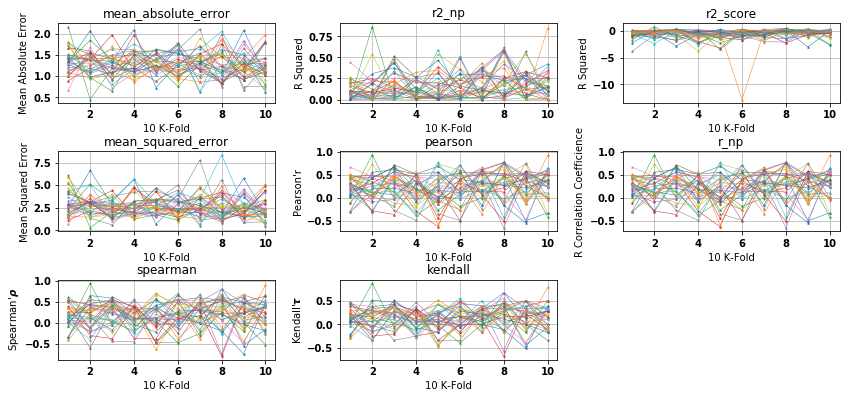

In [13]:
plt.clf()
plt.figure(figsize=(14,18))
plot_index=1

for c in condition_list:
    plt.subplot(len(condition_list), 3, plot_index)
    for i in range(32):
        data = []
        for j in range(10):
            y = []
            pred = []
            model_key = 'model'+str(i)+'_split'+str(j)
            for o in original_data[model_key]:
                y.append(o)
            for p in predict_data[model_key]:
                pred.append(p)
            y_ = np.array(y) 
            pred_ = np.array(pred)
            correlation = locals()[c](y_, pred_)
            if 'pearson' in c or 'spearman' in c or 'kendall' in c:
                correlation = correlation[0]
            data.append(correlation)
        plt.plot(data,'-^', lw = 0.5,markersize=1.5)
    plt.title(c)
    plt.xticks([1,3,5,7,9],['2','4','6','8','10'])
    plt.ylabel(y_axis_labels[c])
    plt.grid(axis='y',alpha=0.9)
    plt.grid(axis='x',alpha=0.9)
    plt.xlabel('10 K-Fold')
    plot_index+=1
plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(wspace=0.3)
plt.show()


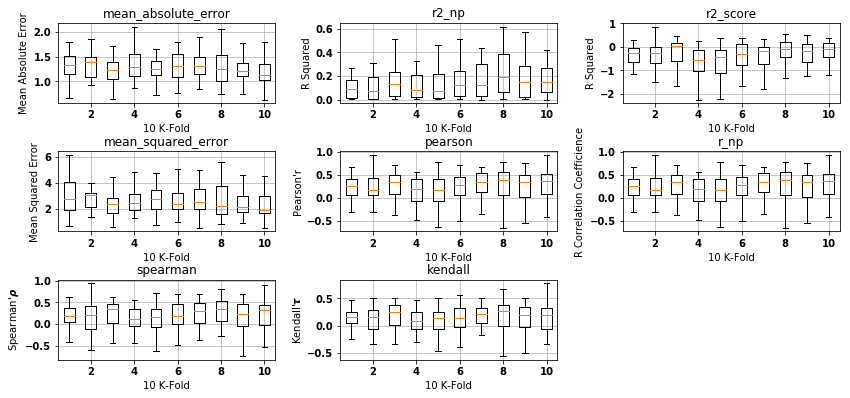

In [14]:
# Box plot
plt.clf()
plt.figure(figsize=(14,18))
plot_index=1

# Didn't do average, Didn't do bootstraping

for c in condition_list:
    box_data =[]
    plt.subplot(len(condition_list), 3, plot_index)
    for j in range(10):# 10 fold
        data = []
        for i in range(32):
            y = []
            pred = []
            model_key = 'model'+str(i)+'_split'+str(j)
            for o in original_data[model_key]:
                y.append(o)
            for p in predict_data[model_key]:
                pred.append(p)
            y_ = np.array(y)       
            pred_ = np.array(pred)
            correlation = locals()[c](y_, pred_)
            if 'pearson' in c or 'spearman' in c or 'kendall' in c:
                correlation = correlation[0]
            data.append(correlation)
        box_data.append(data)
    plt.boxplot(box_data, showfliers=False)    
    plt.title(c)
    plt.xticks([2,4,6,8,10],['2','4','6','8','10'])
    plt.ylabel(y_axis_labels[c])
    plt.grid(axis='y',alpha=0.9)
    plt.grid(axis='x',alpha=0.9)
    plt.xlabel('10 K-Fold')
    plot_index+=1
plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(wspace=0.3)
plt.show()


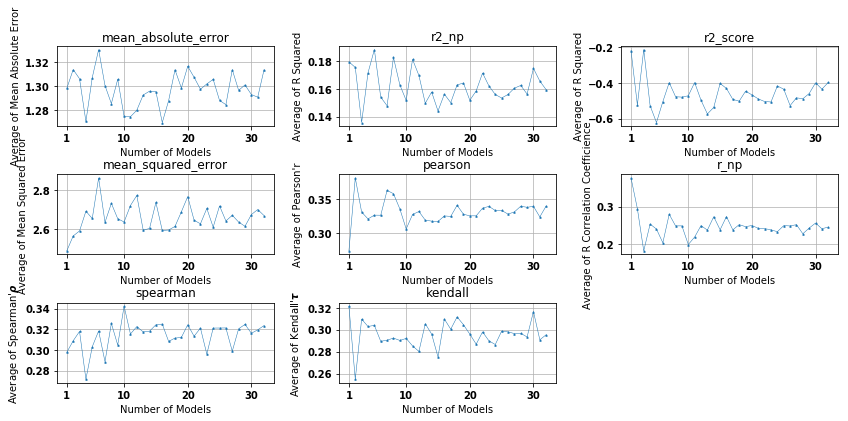

In [15]:
plt.clf()
plt.figure(figsize=(14,18))
plot_index=1

for c in condition_list:
    plt.subplot(len(condition_list), 3, plot_index)
    multi_models_r = []
    multi_models_r_std = []
    for msize in range(1,33):
        mean_r_based_on_multi_models = []
        for _ in range(100):        # bootstrap 100 times for selecting random models.
            select_modes = np.random.choice(32,msize)
            data = []
            for i in select_modes:
                for j in range(10):
                    y = []
                    pred = []
                    model_key = 'model'+str(i)+'_split'+str(j)
                    for o in original_data[model_key]:
                        y.append(o)
                    for p in predict_data[model_key]:
                        pred.append(p)
                    y_ = np.array(y) # cumulate models
                    pred_ = np.array(pred)
                    correlation = locals()[c](y_, pred_)
                    data.append(correlation)
            tem_mean_r = np.mean(data) # average selected models
        mean_r_based_on_multi_models.append(tem_mean_r)
        multi_models_r.append(np.mean(mean_r_based_on_multi_models))
        multi_models_r_std.append(np.std(mean_r_based_on_multi_models))
    plt.errorbar(range(32),multi_models_r,yerr=multi_models_r_std, fmt='-^', lw = 0.5,markersize=1.5)
    plt.title(c)
    plt.xticks([0,9,19,29],['1','10','20','30'])
    plt.ylabel('Average of '+y_axis_labels[c])
    plt.grid(axis='y',alpha=0.9)
    plt.grid(axis='x',alpha=0.9)
    plt.xlabel('Number of Models')
    plot_index+=1
plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(wspace=0.3)
plt.show()

In [16]:
# This is for 5 K-Fold, Random split dataset
os.chdir('/home/bxie/PycharmProjects/KDEL/benchmark/building_new_model/95_training_database_predict_104batch_validation_2/rnn_modular_package')
import glob
FNs = glob.glob('cross_validation_checkpoint*.txt')
original_data ={}
predict_data = {}
for FN in FNs:
    orig_data, pre_data, model_num, split_num = read_prediction_data(FN)
    original_data['model'+str(model_num)+'_split'+str(split_num)] = orig_data
    predict_data['model'+str(model_num)+'_split'+str(split_num)] = pre_data

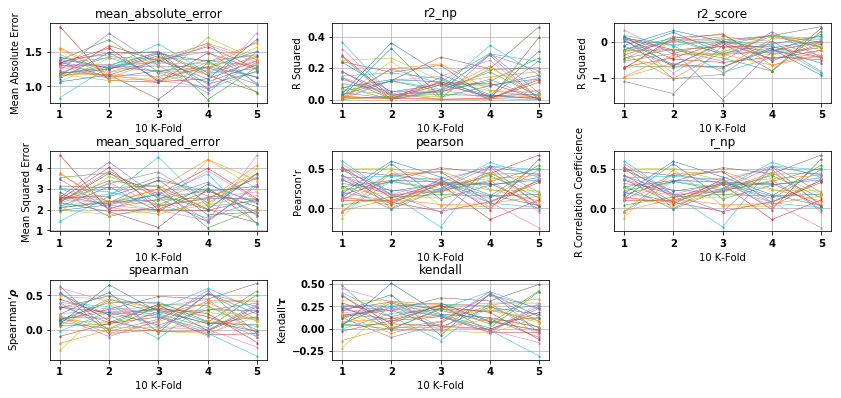

In [20]:
plt.clf()
plt.figure(figsize=(14,18))
plot_index=1

for c in condition_list:
    plt.subplot(len(condition_list), 3, plot_index)
    for i in range(32):
        data = []
        for j in range(5):
            y = []
            pred = []
            model_key = 'model'+str(i)+'_split'+str(j)
            for o in original_data[model_key]:
                y.append(o)
            for p in predict_data[model_key]:
                pred.append(p)
            y_ = np.array(y) 
            pred_ = np.array(pred)
            correlation = locals()[c](y_, pred_)
            if 'pearson' in c or 'spearman' in c or 'kendall' in c:
                correlation = correlation[0]
            data.append(correlation)
        plt.plot(data,'-^', lw = 0.5,markersize=1.5)
    plt.title(c)
    plt.xticks([0,1,2,3,4],['1','2','3','4','5'])
    plt.ylabel(y_axis_labels[c])
    plt.grid(axis='y',alpha=0.9)
    plt.grid(axis='x',alpha=0.9)
    plt.xlabel('10 K-Fold')
    plot_index+=1
plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(wspace=0.3)
plt.show()

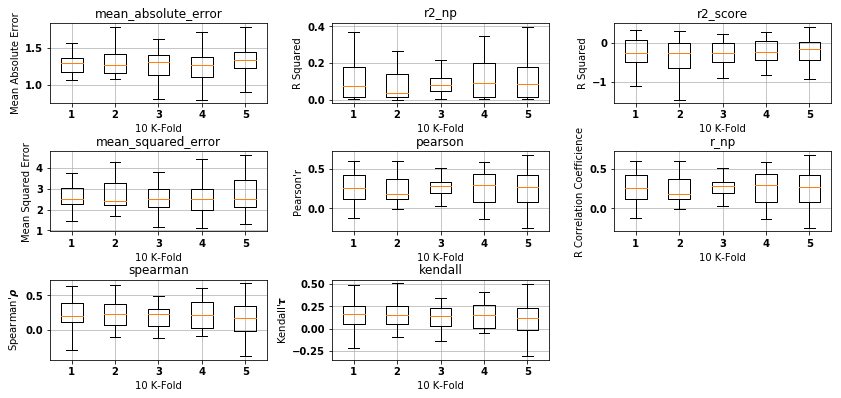

In [21]:
# Box plot
plt.clf()
plt.figure(figsize=(14,18))
plot_index=1

# Didn't do average, Didn't do bootstraping

for c in condition_list:
    box_data =[]
    plt.subplot(len(condition_list), 3, plot_index)
    for j in range(5):# 10 fold
        data = []
        for i in range(32):
            y = []
            pred = []
            model_key = 'model'+str(i)+'_split'+str(j)
            for o in original_data[model_key]:
                y.append(o)
            for p in predict_data[model_key]:
                pred.append(p)
            y_ = np.array(y)       
            pred_ = np.array(pred)
            correlation = locals()[c](y_, pred_)
            if 'pearson' in c or 'spearman' in c or 'kendall' in c:
                correlation = correlation[0]
            data.append(correlation)
        box_data.append(data)
    plt.boxplot(box_data, showfliers=False)    
    plt.title(c)
    plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
    plt.ylabel(y_axis_labels[c])
    plt.grid(axis='y',alpha=0.9)
    plt.grid(axis='x',alpha=0.9)
    plt.xlabel('10 K-Fold')
    plot_index+=1
plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(wspace=0.3)
plt.show()

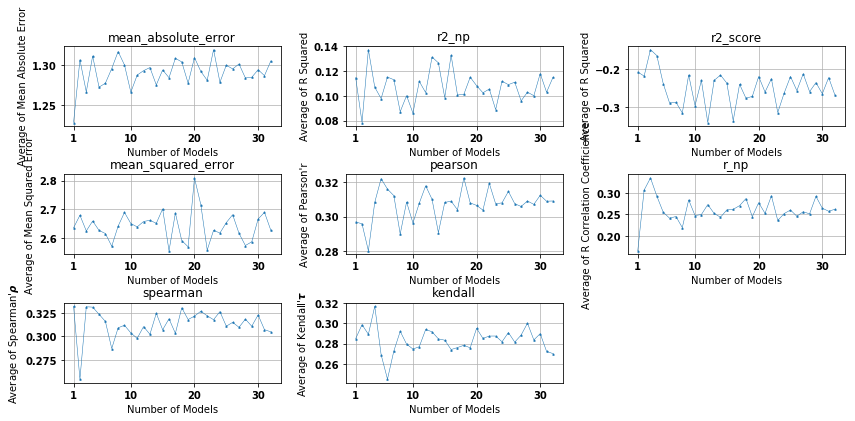

In [22]:
plt.clf()
plt.figure(figsize=(14,18))
plot_index=1

for c in condition_list:
    plt.subplot(len(condition_list), 3, plot_index)
    multi_models_r = []
    multi_models_r_std = []
    for msize in range(1,33):
        mean_r_based_on_multi_models = []
        for _ in range(100):        # bootstrap 100 times for selecting random models.
            select_modes = np.random.choice(32,msize)
            data = []
            for i in select_modes:
                for j in range(5):
                    y = []
                    pred = []
                    model_key = 'model'+str(i)+'_split'+str(j)
                    for o in original_data[model_key]:
                        y.append(o)
                    for p in predict_data[model_key]:
                        pred.append(p)
                    y_ = np.array(y) # cumulate models
                    pred_ = np.array(pred)
                    correlation = locals()[c](y_, pred_)
                    data.append(correlation)
            tem_mean_r = np.mean(data) # average selected models
        mean_r_based_on_multi_models.append(tem_mean_r)
        multi_models_r.append(np.mean(mean_r_based_on_multi_models))
        multi_models_r_std.append(np.std(mean_r_based_on_multi_models))
    plt.errorbar(range(32),multi_models_r,yerr=multi_models_r_std, fmt='-^', lw = 0.5,markersize=1.5)
    plt.title(c)
    plt.xticks([0,9,19,29],['1','10','20','30'])
    plt.ylabel('Average of '+y_axis_labels[c])
    plt.grid(axis='y',alpha=0.9)
    plt.grid(axis='x',alpha=0.9)
    plt.xlabel('Number of Models')
    plot_index+=1
plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(wspace=0.3)
plt.show()